# Atlantic Basin

In [2]:
#pip install flox

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
from xhistogram.xarray import histogram
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
from flox.xarray import xarray_reduce

In [4]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

# Load Data

In [71]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/atl_basin.nc', chunks={'N_PROF':1000})

In [72]:
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))
ds

<xarray.Dataset> Size: 7GB
Dimensions:            (N_PROF: 135902, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW         (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    MLD                (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    month_frac         (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    year_frac          (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 1MB 0 1 2 3 ... 135899 135900 135901
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 544kB dask.array<chunksize=(1000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 544kB dask.array<chunksize=(1000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/01/17
    Fetched_constraints:  [x=5.00/10.00; y=-50.00/-45.00; z=0.0/2000.0]
    Fetched_uri:          
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [73]:
x='LATITUDE'
y='PRES_INTERPOLATED'
sample_max = 2.5

In [74]:
ds= ds.sortby(x).persist()
boolean_indexer = (ds.sample_rate < sample_max).compute()
ds = ds.where(boolean_indexer, drop=True)

Text(0.5, 1.0, 'Profiles with sample_rate < 2.5m')

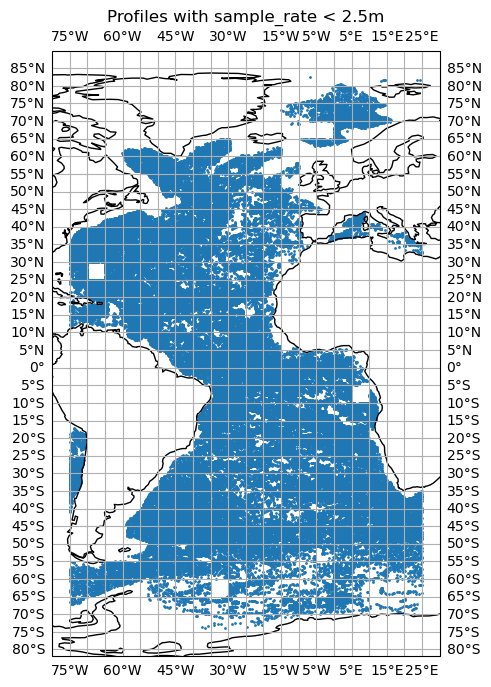

In [75]:
fig = plt.figure(figsize=(5, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(xlocs=np.arange(-80,30,5), ylocs=np.arange(-90,90,5), draw_labels=True)

ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=1)
plt.title('Profiles with sample_rate < 2.5m')

# Calculate Terms

In [10]:
lfilt = 100

ct_b = ds.CT
sa_b = ds.SA

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds, lfilt, 'SA')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m

In [11]:
K_rho4 = 10**(-4)
K_rho5 = 10**(-5)
K_rho6 = 10**(-6)

In [12]:
ct_2 = K_rho5*ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)
sa_2 = K_rho5*ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)

ct_3 = K_rho5*(ct_m.differentiate(coord='PRES_INTERPOLATED'))**2
sa_3 = K_rho5*(sa_m.differentiate(coord='PRES_INTERPOLATED'))**2

In [14]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

# Binning with flox

In [215]:
deg = 3

In [216]:
lon_bins = np.arange(-75,25,deg)
lat_bins = np.arange(-75,85,deg)

In [313]:
ds_ct_binned = xarray_reduce(
    ds.CT,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [218]:
ds_sa_binned = xarray_reduce(
    ds.SA,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [414]:
ds_sig_binned = xarray_reduce(
    ds.SIG0,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [219]:
ct_2_binned = xarray_reduce(
    ct_2,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [220]:
ct_3_binned = xarray_reduce(
    ct_3,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [265]:
 ct_2rat_binned = xarray_reduce(
    ct_2rat,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [221]:
sa_2_binned = xarray_reduce(
    sa_2,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [222]:
sa_3_binned = xarray_reduce(
    sa_3,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [266]:
sa_2rat_binned = xarray_reduce(
    sa_2rat,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

# Gridded Sections

### Make depth, lon, lat selections

In [462]:
depth = 500
lon   = 18
lat   = 20
levels = [26,27,27.4,27.7,27.8]

In [463]:
print('depth: {}m'.format(depth))
print('lon bin: {}'.format(ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()))
print('lat_bin: {}'.format(ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()))
print('SIG0 levels: {}'.format(levels))

depth: 500m
lon bin: (-21, -18]
lat_bin: (-15, -12]
SIG0 levels: [26, 27, 27.4, 27.7, 27.8]


In [464]:
ct_start = 0
ct_end   = 16
ct_norm  = colors.Normalize(vmin=ct_start, vmax=ct_end)
ct_cmap  = cmo.thermal

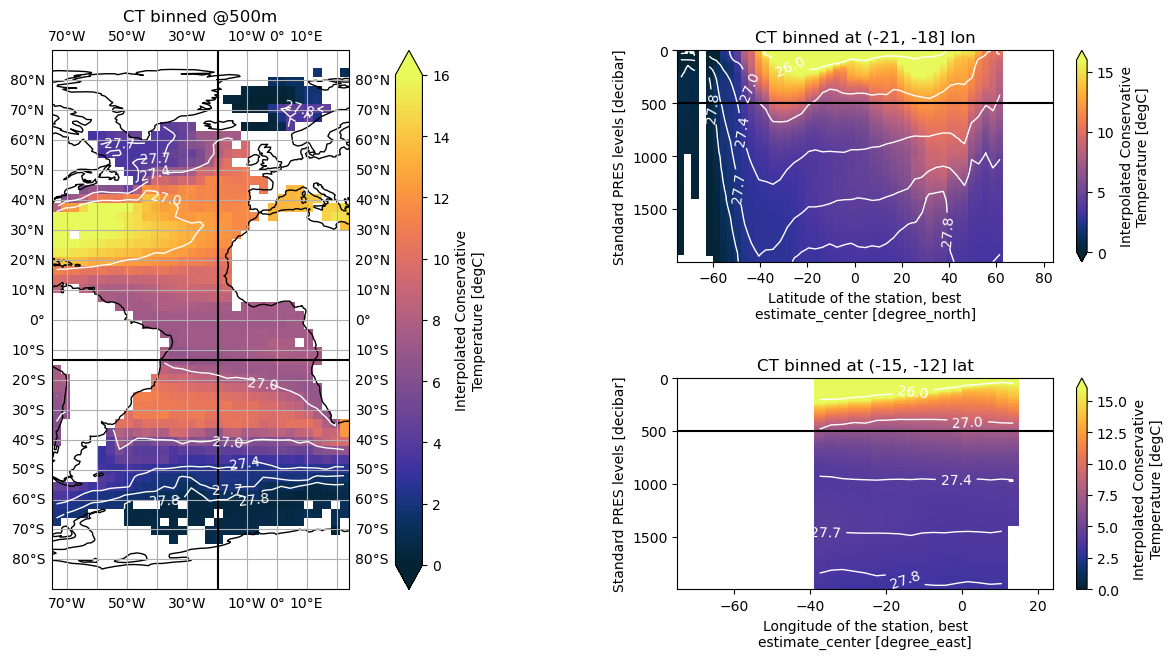

In [465]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = ds_ct_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = ds_ct_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = ds_ct_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = ds_ct_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ds_ct_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=ct_norm, cmap=ct_cmap)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'CT binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ds_ct_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=ct_norm, cmap=ct_cmap)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'CT binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ds_ct_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=ct_norm, cmap=ct_cmap)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'CT binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()

In [466]:
sa_start = 34.5
sa_end   = 36.5
sa_norm  = colors.Normalize(vmin=sa_start, vmax=sa_end)
sa_cmap  = cmo.haline

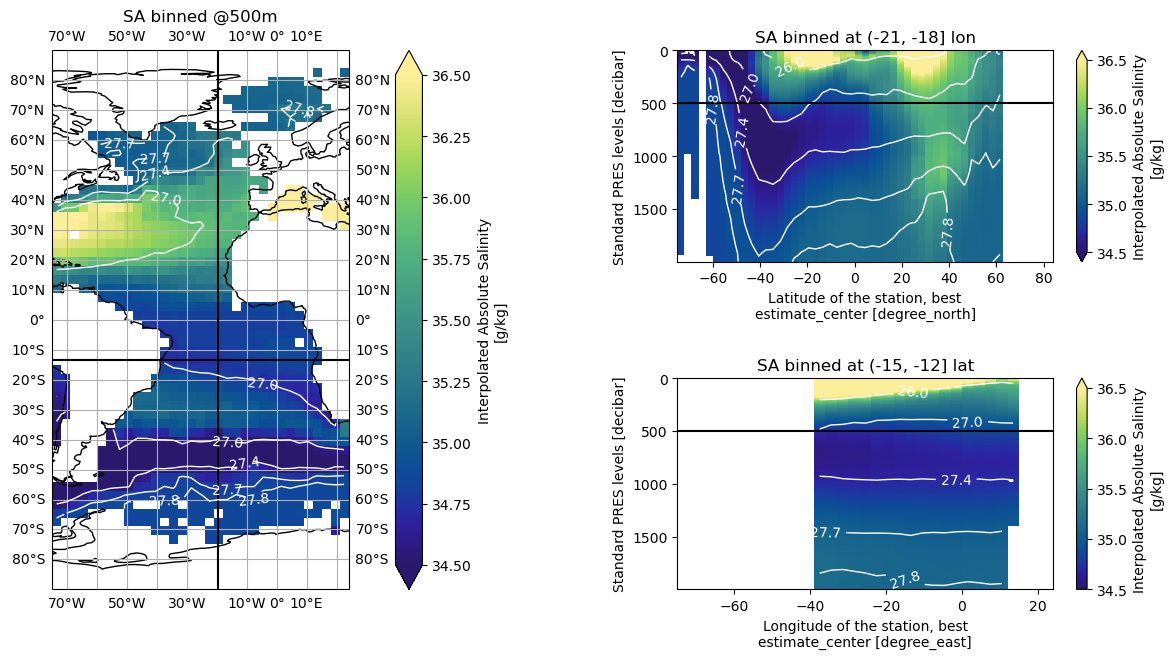

In [467]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ds_sa_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=sa_norm, cmap=sa_cmap)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'SA binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ds_sa_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=sa_norm, cmap=sa_cmap)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'SA binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ds_sa_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=sa_norm, cmap=sa_cmap)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'SA binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()

In [468]:
ctvar_start = 10**-12
ctvar_end   = 10**-8
ctvar_norm  = colors.LogNorm(vmin=ctvar_start, vmax=ctvar_end)
var_cmap  = cmo.matter_r

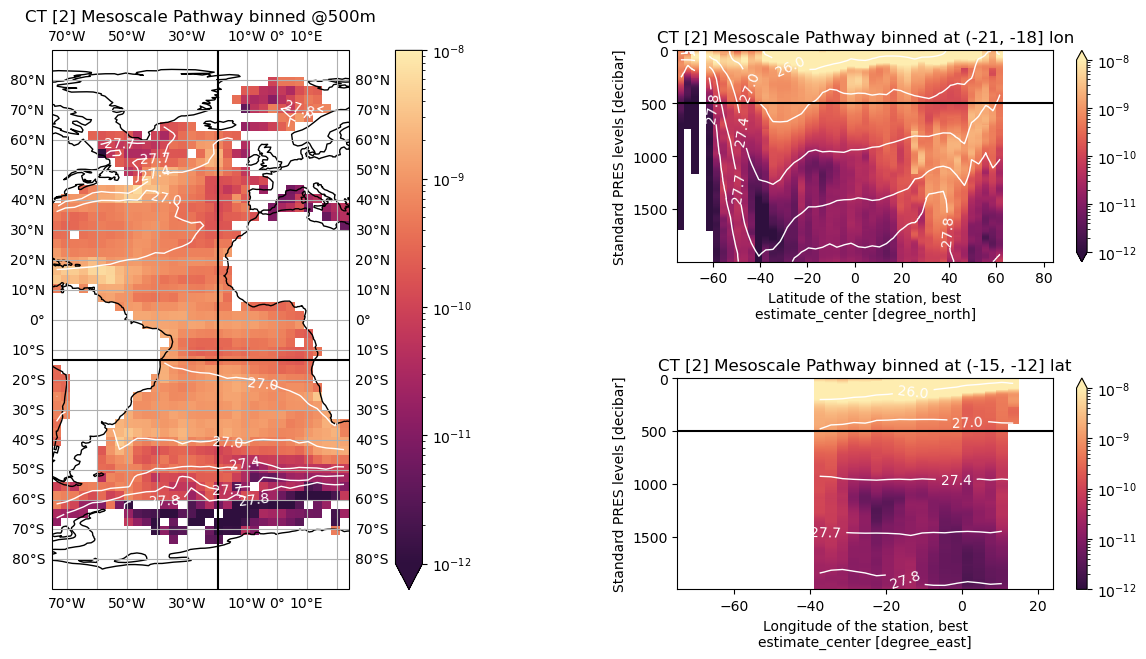

In [469]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = ct_2_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = ct_2_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = ct_2_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = ct_2_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ct_2_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=ctvar_norm, cmap=var_cmap)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'CT [2] Mesoscale Pathway binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_2_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=ctvar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'CT [2] Mesoscale Pathway binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ct_2_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=ctvar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'CT [2] Mesoscale Pathway binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()

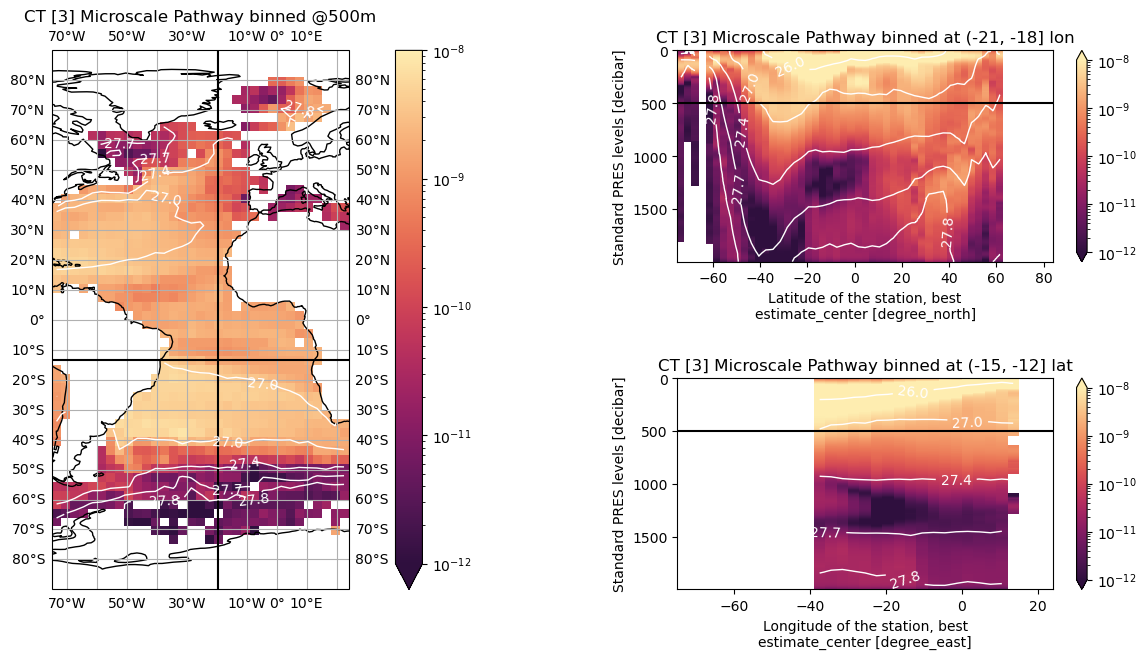

In [470]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = ct_3_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = ct_3_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = ct_3_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = ct_3_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ct_3_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=ctvar_norm, cmap=var_cmap)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'CT [3] Microscale Pathway binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_3_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=ctvar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'CT [3] Microscale Pathway binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ct_3_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=ctvar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'CT [3] Microscale Pathway binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()

In [471]:
savar_start = 10**-14
savar_end   = 10**-9
savar_norm  = colors.LogNorm(vmin=savar_start, vmax=savar_end)

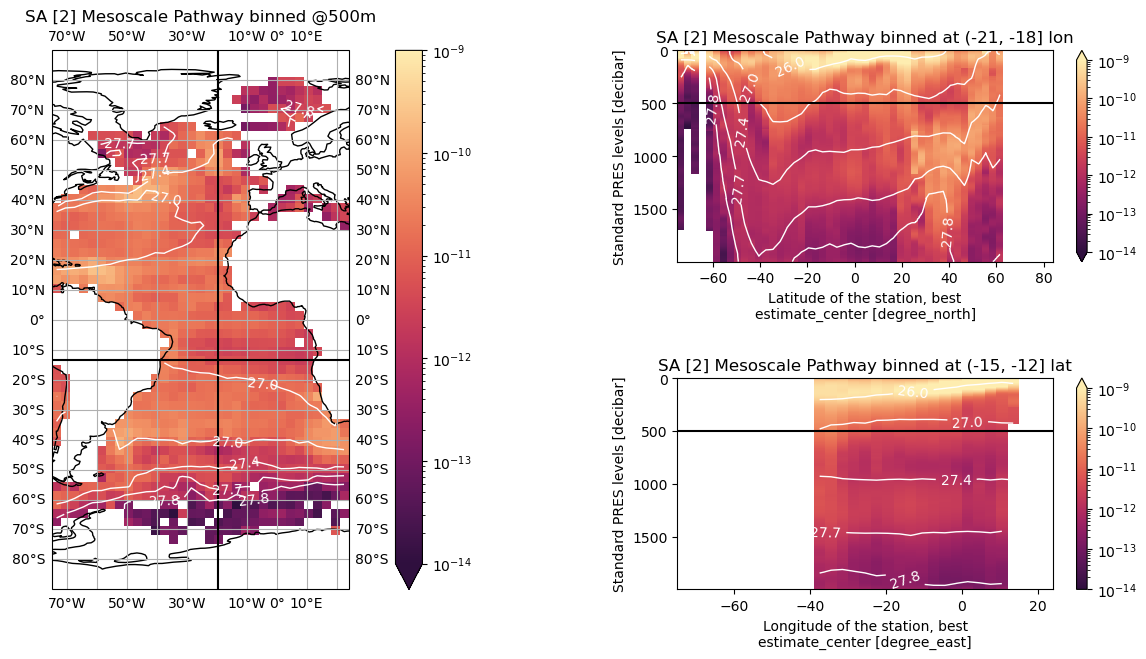

In [472]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = sa_2_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = sa_2_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = sa_2_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = sa_2_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
sa_2_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=savar_norm, cmap=var_cmap)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'SA [2] Mesoscale Pathway binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
sa_2_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=savar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'SA [2] Mesoscale Pathway binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
sa_2_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=savar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'SA [2] Mesoscale Pathway binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()

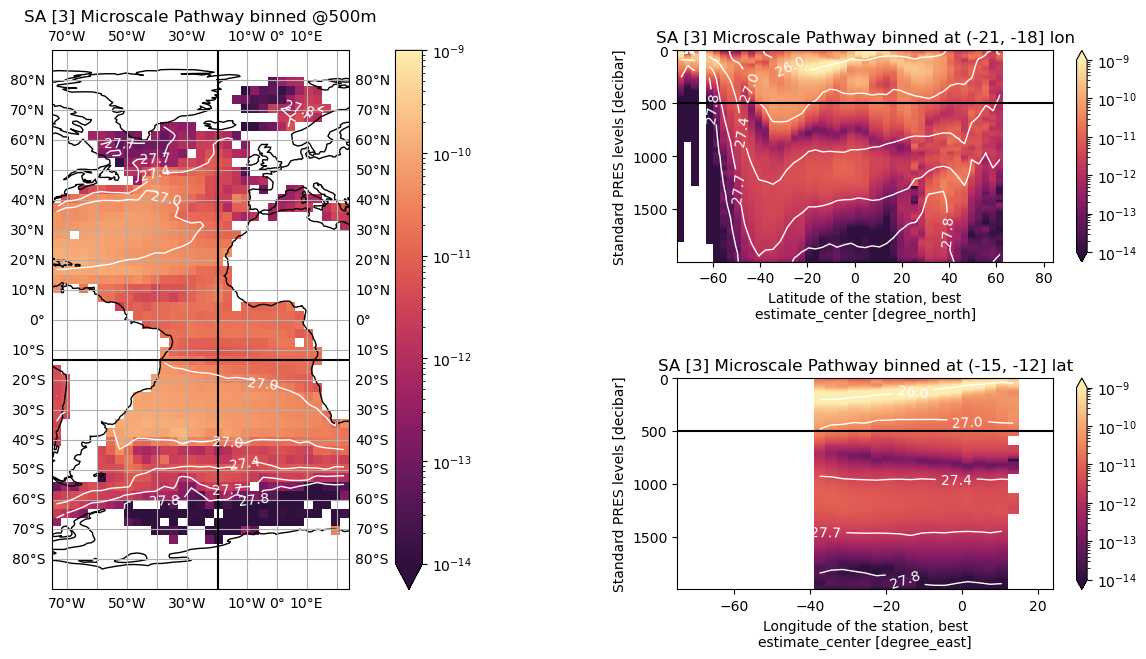

In [473]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = sa_3_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = sa_3_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = sa_3_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = sa_3_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
sa_3_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=savar_norm, cmap=var_cmap)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'SA [3] Microscale Pathway binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
sa_3_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=savar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'SA [3] Microscale Pathway binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
sa_3_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=savar_norm, cmap=var_cmap)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'SA [3] Microscale Pathway binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()

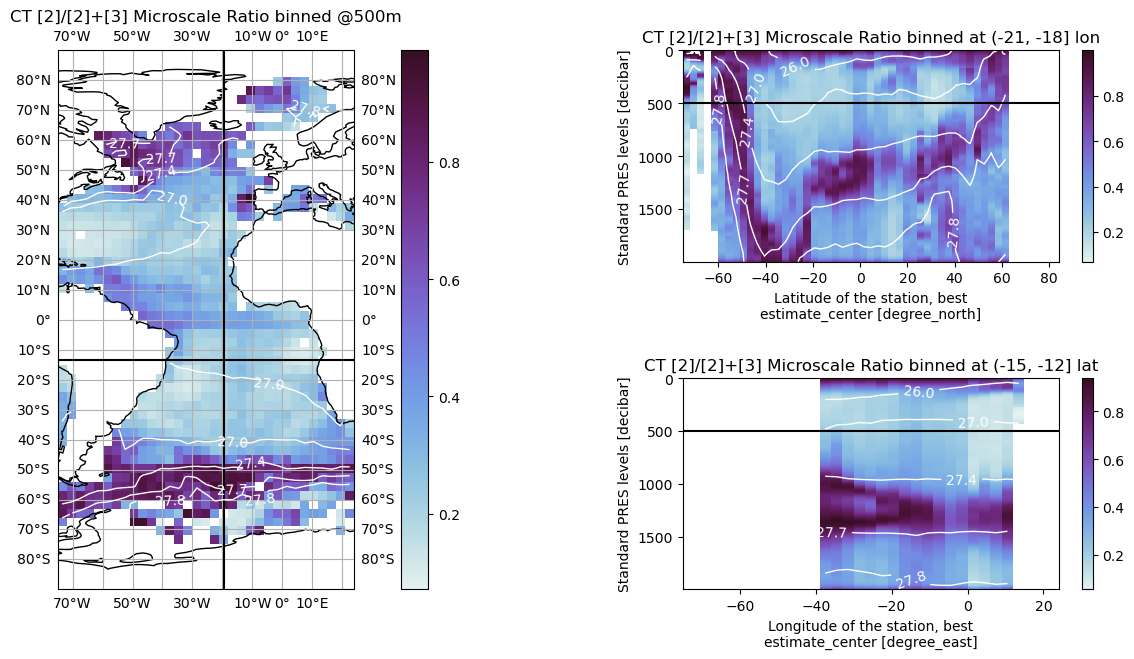

In [474]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

lon_left = ct_2rat_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = ct_2rat_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = ct_2rat_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = ct_2rat_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ct_2rat_binned.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, cmap=cmo.dense)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'CT [2]/[2]+[3] Microscale Ratio binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_2rat_binned.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, cmap=cmo.dense)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'CT [2]/[2]+[3] Microscale Ratio binned at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ct_2rat_binned.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, cmap=cmo.dense)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'CT [2]/[2]+[3] Microscale Ratio binned at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()